# Import Libraries

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, KFold
from math import sqrt

plt.style.use('seaborn-darkgrid')

In [8]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [9]:
pseGDP = pd.read_csv('COVID_PSchExpGDP.csv', index_col = 0)
pseGDP.head()

,State,cases,deaths,Public School Expenditure 2016(Thousands),State GDP(Millions),School Expenditures per State GDP(Percent)
0,Alabama,387786,14345,6885677.0,203398.0,3.385322
1,Alaska,18316,367,2319662.0,49429.0,4.692917
2,Arizona,426614,18857,8551673.0,311397.0,2.746228
3,Arkansas,161569,3301,4872214.0,120090.0,4.057135
4,California,2664110,102387,72003129.0,2663396.0,2.703433


In [10]:
pseGDP = pseGDP.drop(columns = ['cases', 'deaths'])
pseGDP.head()

,State,Public School Expenditure 2016(Thousands),State GDP(Millions),School Expenditures per State GDP(Percent)
0,Alabama,6885677.0,203398.0,3.385322
1,Alaska,2319662.0,49429.0,4.692917
2,Arizona,8551673.0,311397.0,2.746228
3,Arkansas,4872214.0,120090.0,4.057135
4,California,72003129.0,2663396.0,2.703433


In [11]:
COVID = pd.read_csv('COVID.csv', index_col = 0)
COVID.head()

,State,cases,deaths
0,Alabama,26912,785
1,Alaska,751,10
2,Arizona,39298,1228
3,Arkansas,13191,188
4,California,159098,5202


In [12]:
COVID = pd.read_csv('COVID.csv', index_col = 0)
COVID.head()

,State,cases,deaths
0,Alabama,26912,785
1,Alaska,751,10
2,Arizona,39298,1228
3,Arkansas,13191,188
4,California,159098,5202


In [13]:
pseGDP = pd.merge(pseGDP, COVID, how = 'left', on = 'State')
pseGDP.head()

,State,Public School Expenditure 2016(Thousands),State GDP(Millions),School Expenditures per State GDP(Percent),cases,deaths
0,Alabama,6885677.0,203398.0,3.385322,26912,785
1,Alaska,2319662.0,49429.0,4.692917,751,10
2,Arizona,8551673.0,311397.0,2.746228,39298,1228
3,Arkansas,4872214.0,120090.0,4.057135,13191,188
4,California,72003129.0,2663396.0,2.703433,159098,5202


In [14]:
test_len = int(0.25 * len(pseGDP))
train_len = len(pseGDP) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = pseGDP[:train_len]
test = pseGDP[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 6)
Test Set Shape: (12, 6)


In [15]:
features_list = ['Public School Expenditure 2016(Thousands)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)




Train MAE Value: 105.92030530098157
Train MSE Value: 17221.902360402142
Train RMS Value: 131.23224588645178
Train R2 Score: 0.9999964416239193


Test MAE Value: 34761.259536743164
Test MSE Value: 7394157569.901708
Test RMS Value: 85989.287529911
Test R2 Score: -9.781322835217514


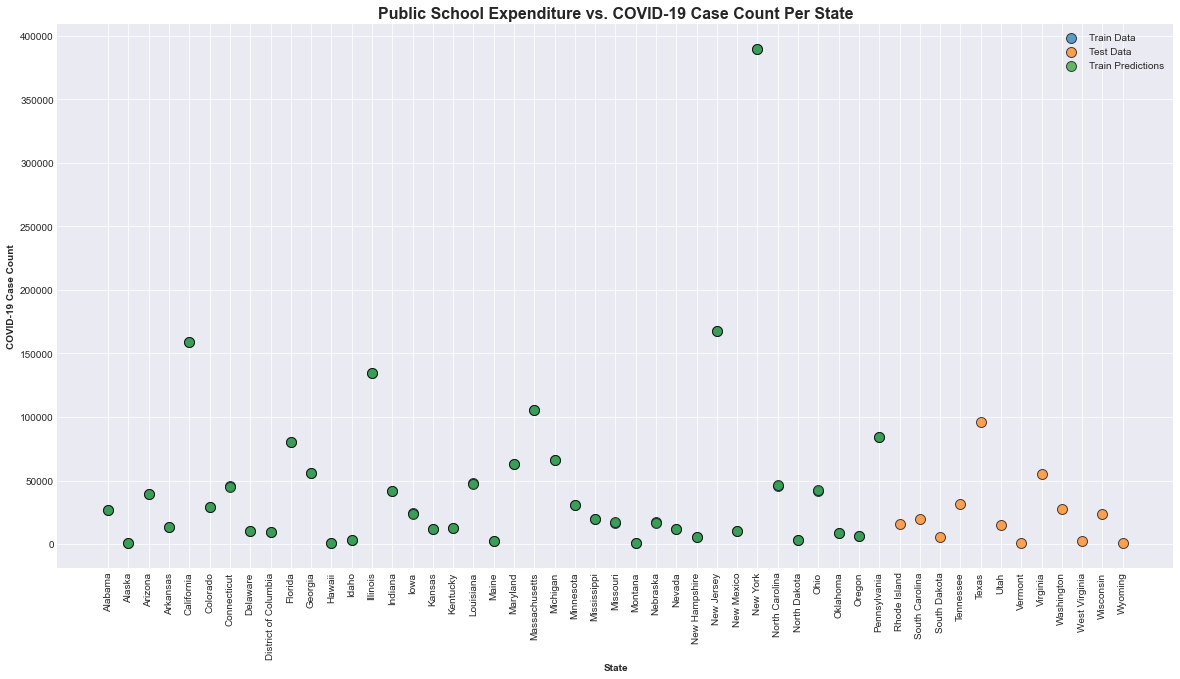

In [16]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Expenditure vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

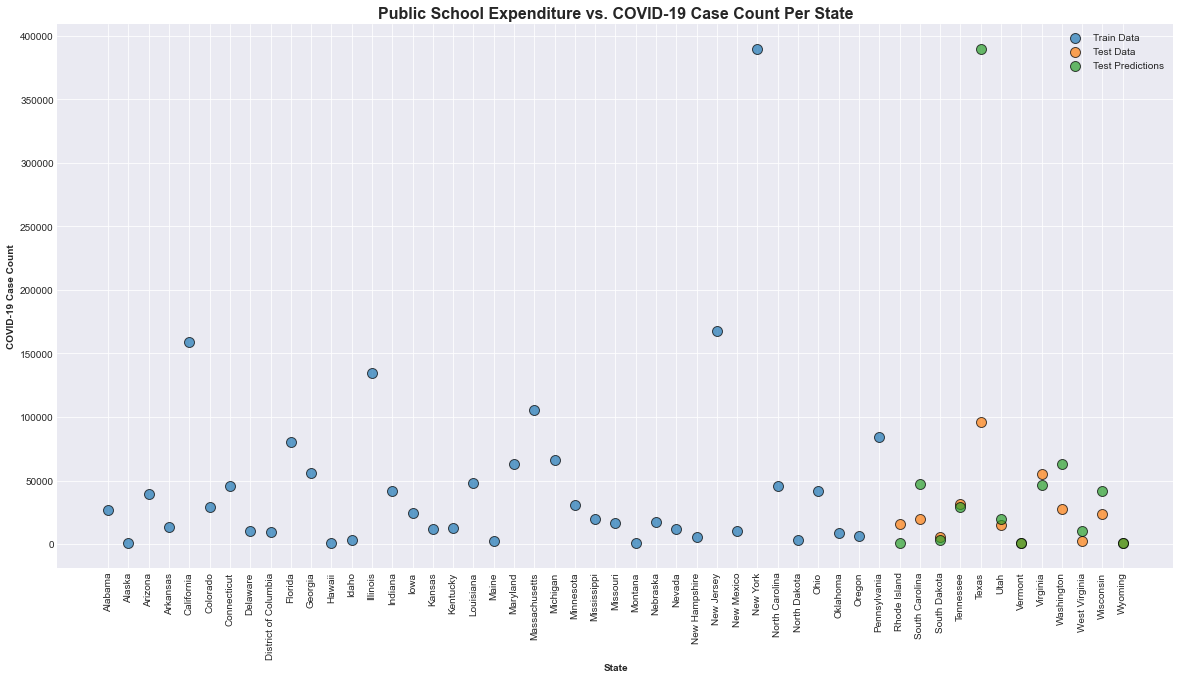

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Expenditure vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [18]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8309 degrees.
Accuracy = 91.25%.


91.2480999334005

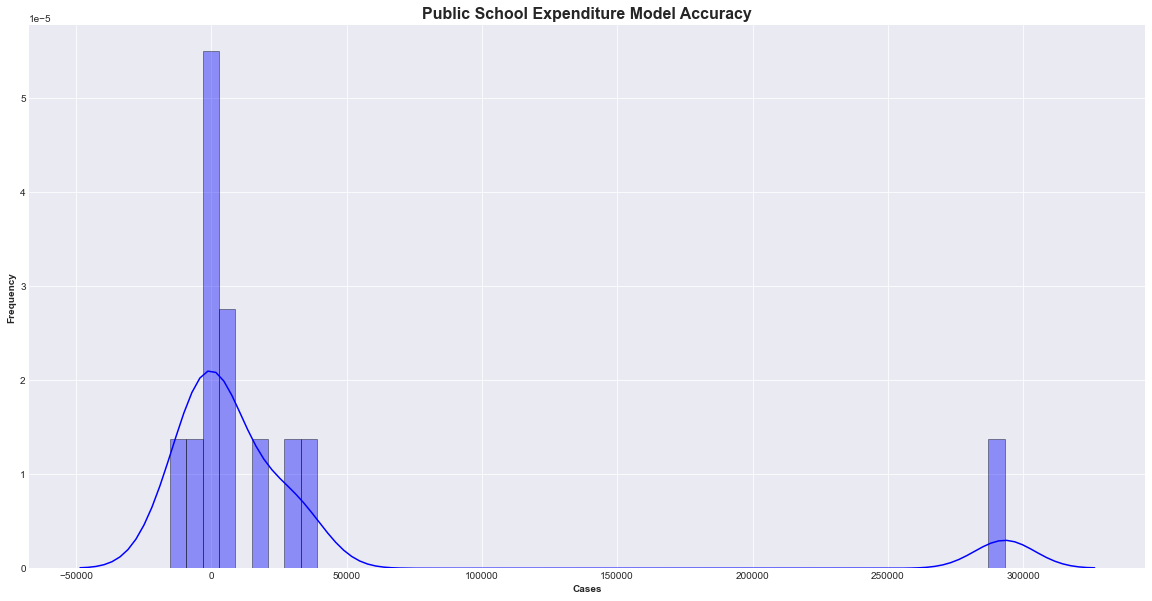

In [19]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Public School Expenditure Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [20]:
features_list = ['State GDP(Millions)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))


XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 107.70518611027644
Train MSE Value: 16373.853894587797
Train RMS Value: 127.9603606379249
Train R2 Score: 0.9999966168470342


Test MAE Value: 33845.06229146322
Test MSE Value: 7362132179.347527
Test RMS Value: 85802.86813007784
Test R2 Score: -9.734627039080571


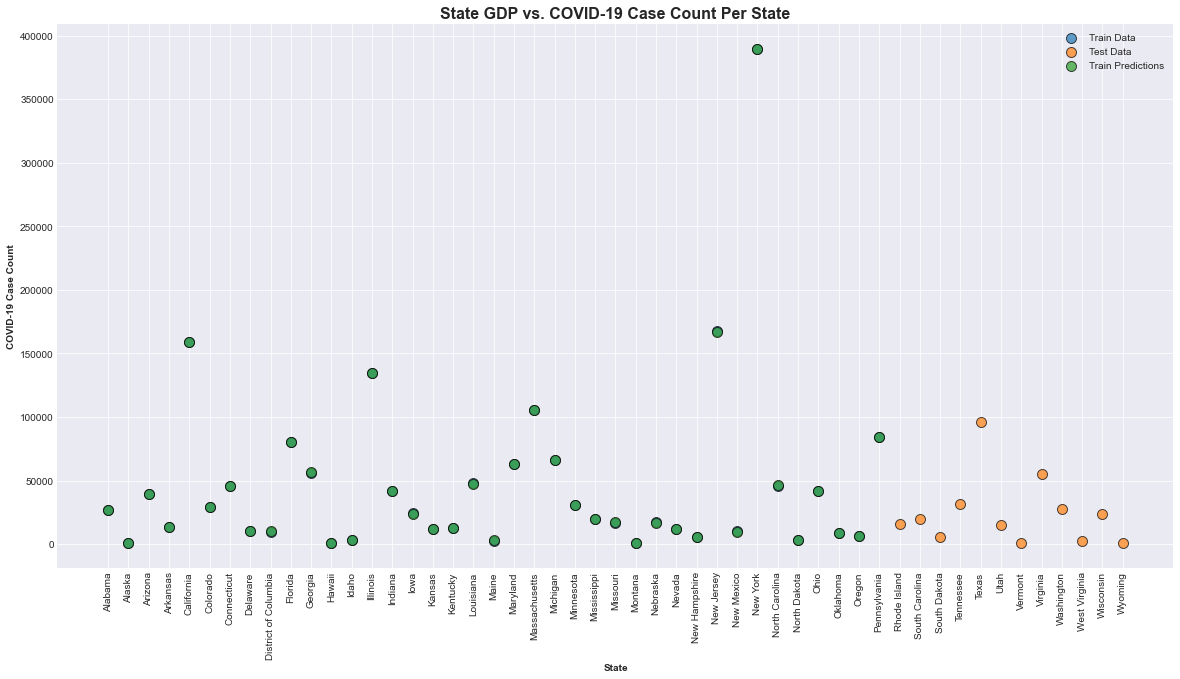

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('State GDP vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


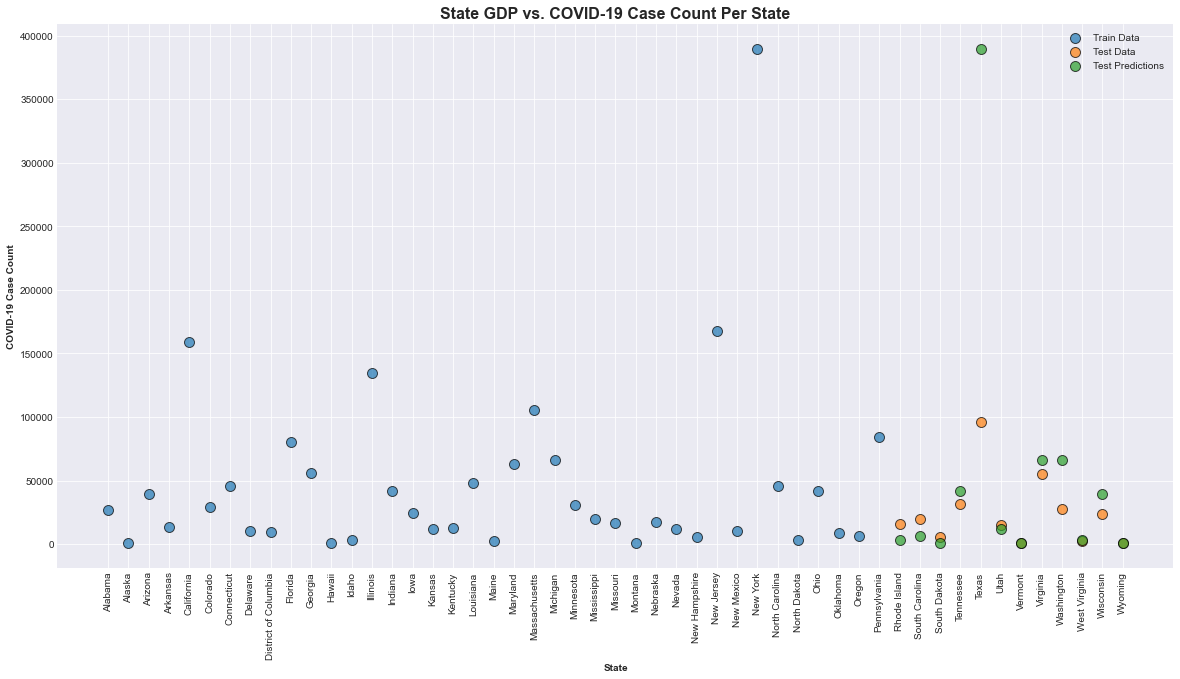

In [22]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('State GDP vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [23]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.24%.


91.24146778371507

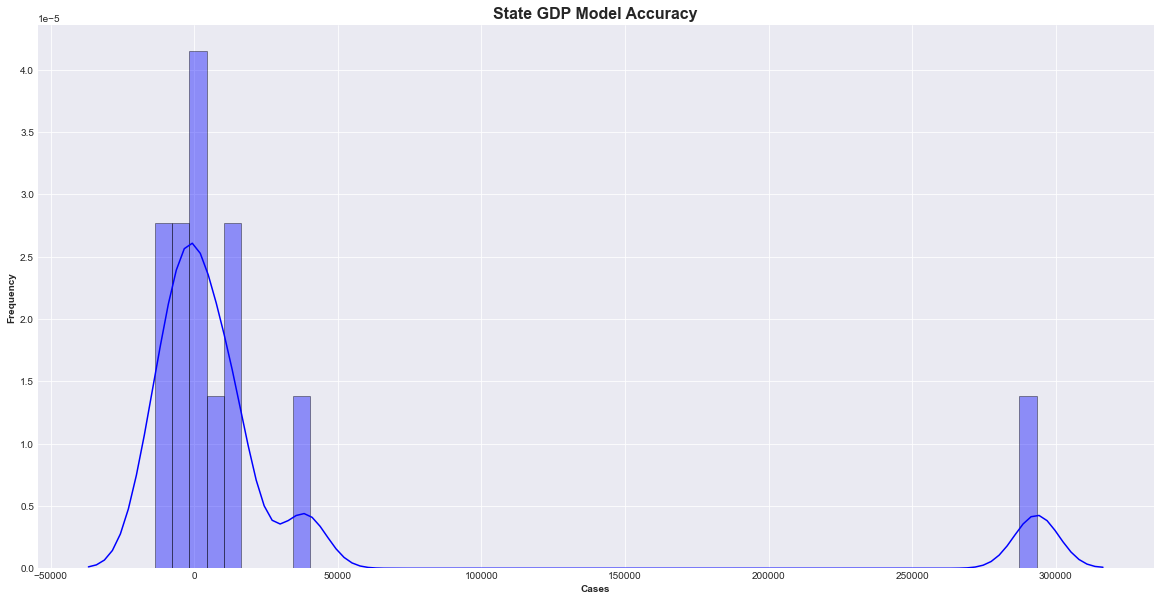

In [24]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('State GDP Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [25]:
features_list = ['School Expenditures per State GDP(Percent)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 134.62230349809695
Train MSE Value: 22497.23387613004
Train RMS Value: 149.990779303696
Train R2 Score: 0.9999953516390216


Test MAE Value: 28985.833887736004
Test MSE Value: 2837043116.0451083
Test RMS Value: 53263.90068371925
Test R2 Score: -3.136654844362531


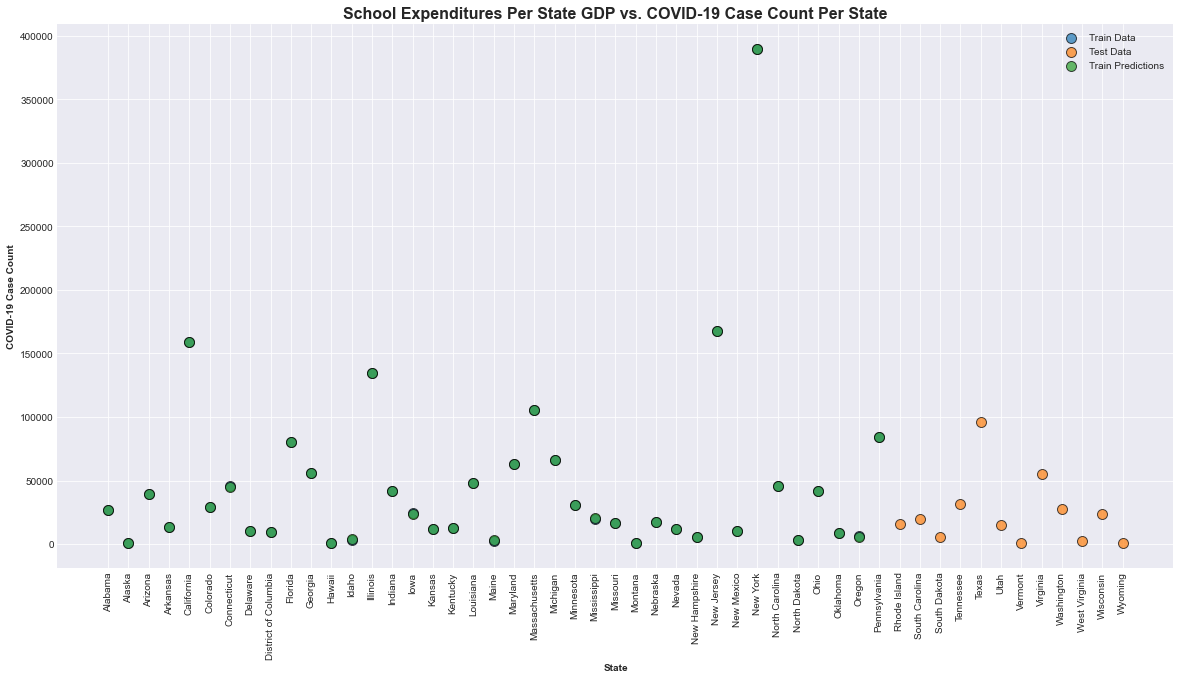

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('School Expenditures Per State GDP vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


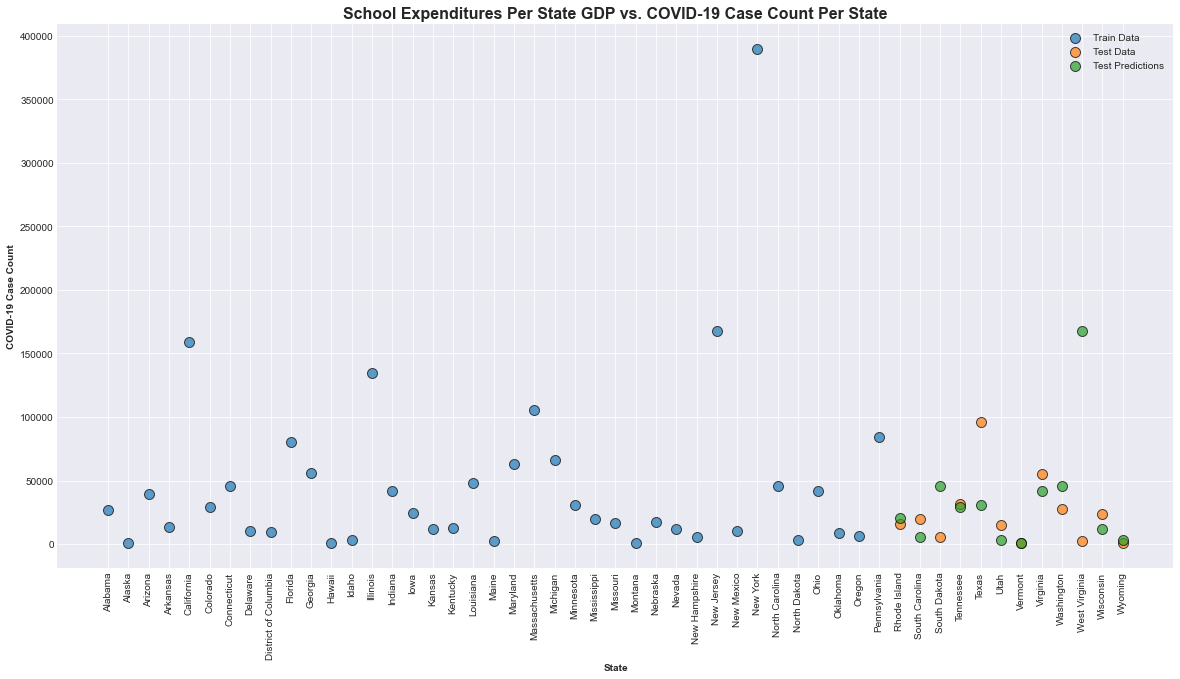

In [27]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('School Expenditures Per State GDP vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [28]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8303 degrees.
Accuracy = 91.21%.


91.2121456769366

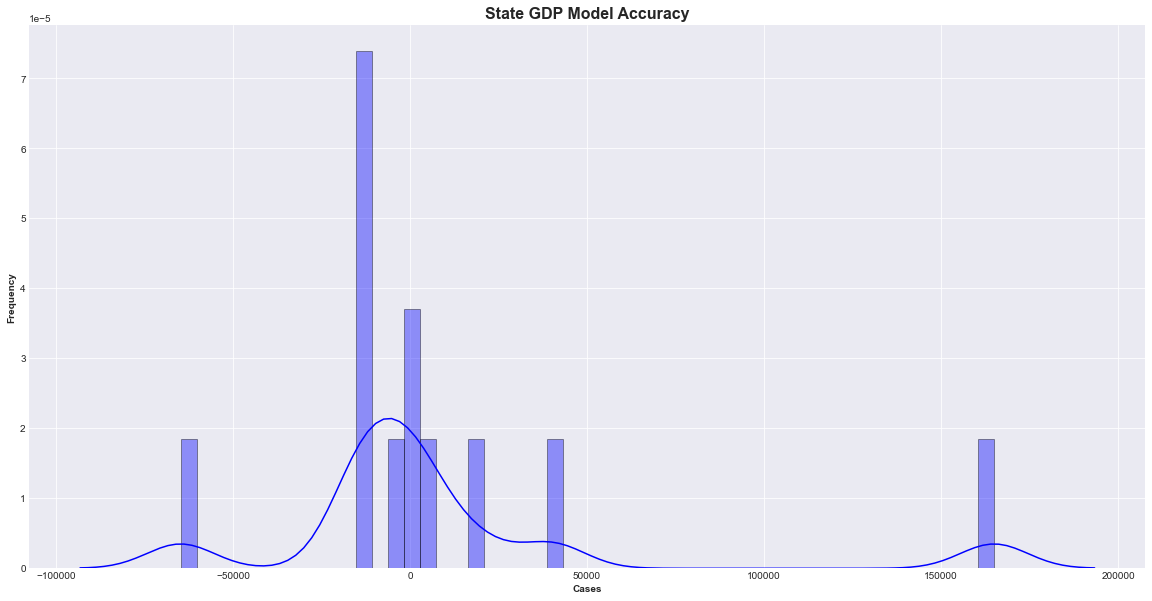

In [29]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('State GDP Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [30]:
features_list = ['Public School Expenditure 2016(Thousands)','State GDP(Millions)','School Expenditures per State GDP(Percent)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 69.47666109525241
Train MSE Value: 9888.385620556868
Train RMS Value: 99.44036213005697
Train R2 Score: 0.9999979568694485


Test MAE Value: 28854.81625366211
Test MSE Value: 6047455751.927291
Test RMS Value: 77765.38916463603
Test R2 Score: -7.817714821039161


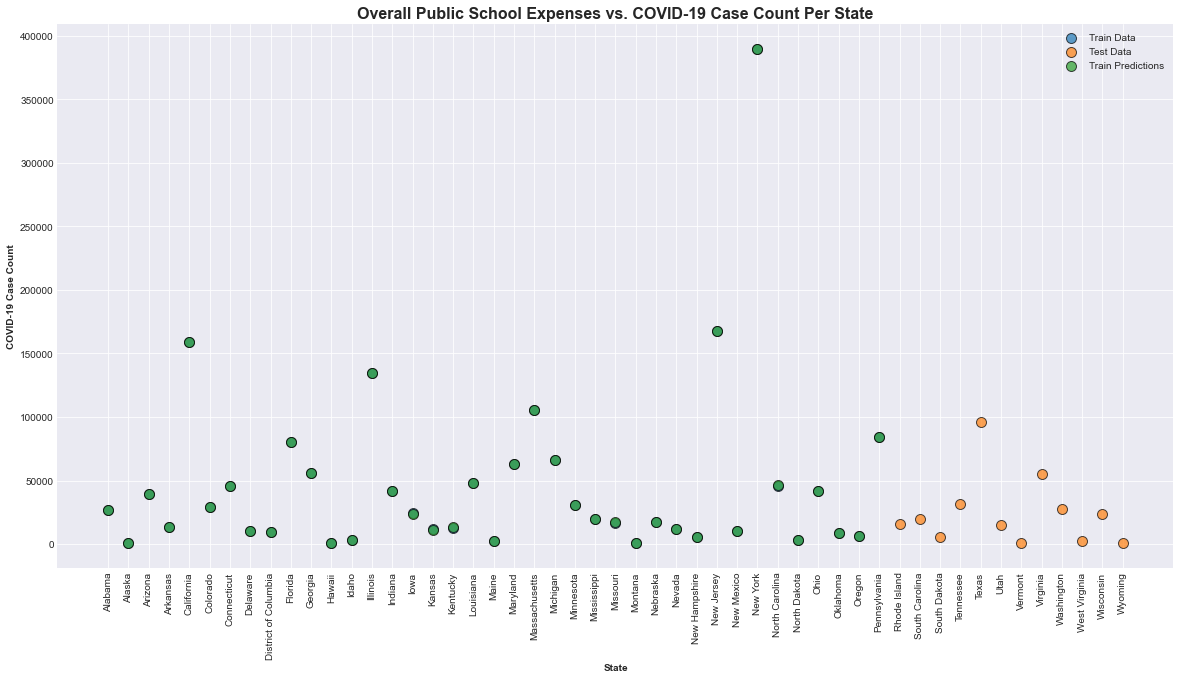

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Public School Expenses vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

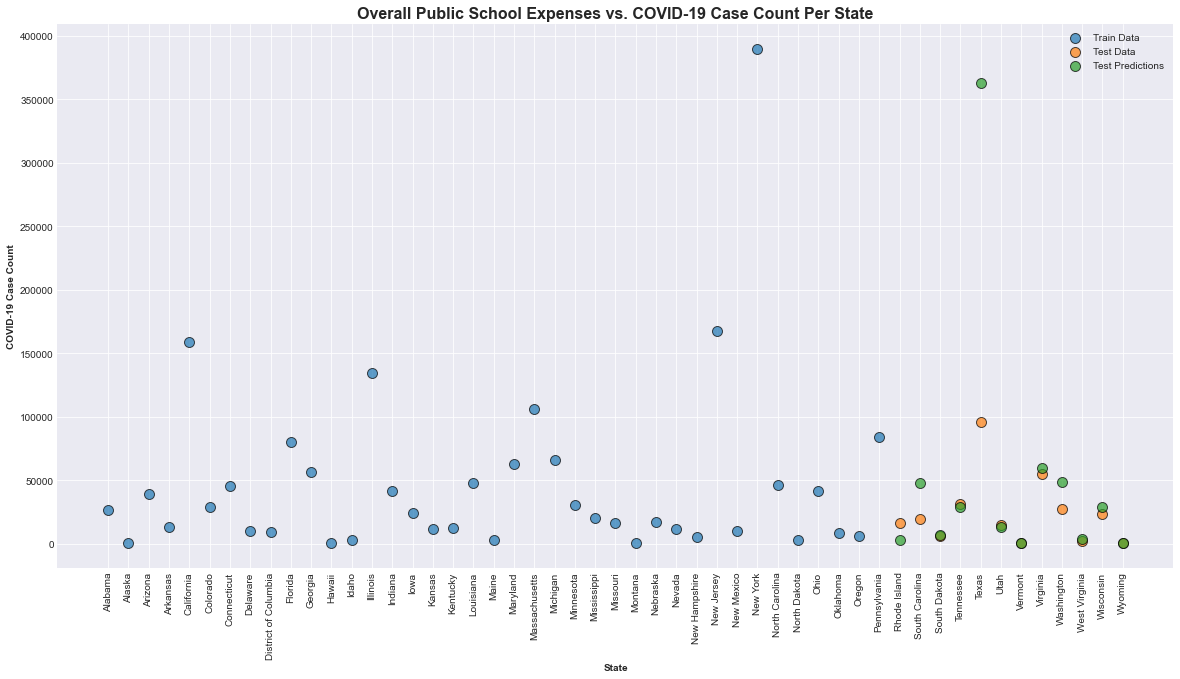

In [32]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Public School Expenses vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [33]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8309 degrees.
Accuracy = 91.25%.


91.24856818229415

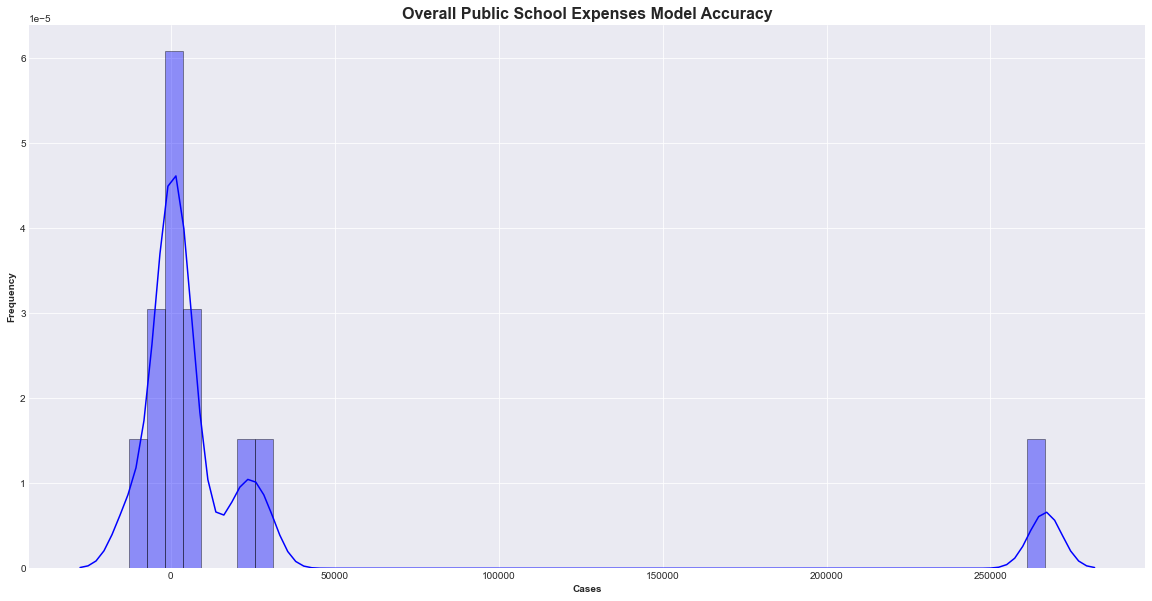

In [34]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Public School Expenses Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [35]:
param_grid = {
    "learning_rate": [0.05, 0.075, 0.1, 0.2, 0.3, 0.4],
    "max_depth": [1, 2, 3, 4, 5, 6, 7],
    "reg_lambda": [1, 1.5, 2, 3, 4.5],
    "min_child_weight": [1, 3, 5, 7],
    "n_estimators": [50, 100, 200, 300, 400, 500, 1000]
}

kfold = KFold(n_splits = 4)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 4 folds for each of 5880 candidates, totalling 23520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 710 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 1373 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1818 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 2345 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3641 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4410 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 5261 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 6192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7205 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 8298 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 9473 tasks      

In [36]:
XG_NewModel.best_params_

{'learning_rate': 0.4,
 'max_depth': 1,
 'min_child_weight': 3,
 'n_estimators': 1000,
 'reg_lambda': 2}

In [37]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 1372.8248322315706
Train MSE Value: 3133481.9566655005
Train RMS Value: 1770.1643869046459
Train R2 Score: 0.9993525623934948


Test MAE Value: 13830.413940429688
Test MSE Value: 696849495.8237495
Test RMS Value: 26397.907034909975
Test R2 Score: -0.016066984103271453


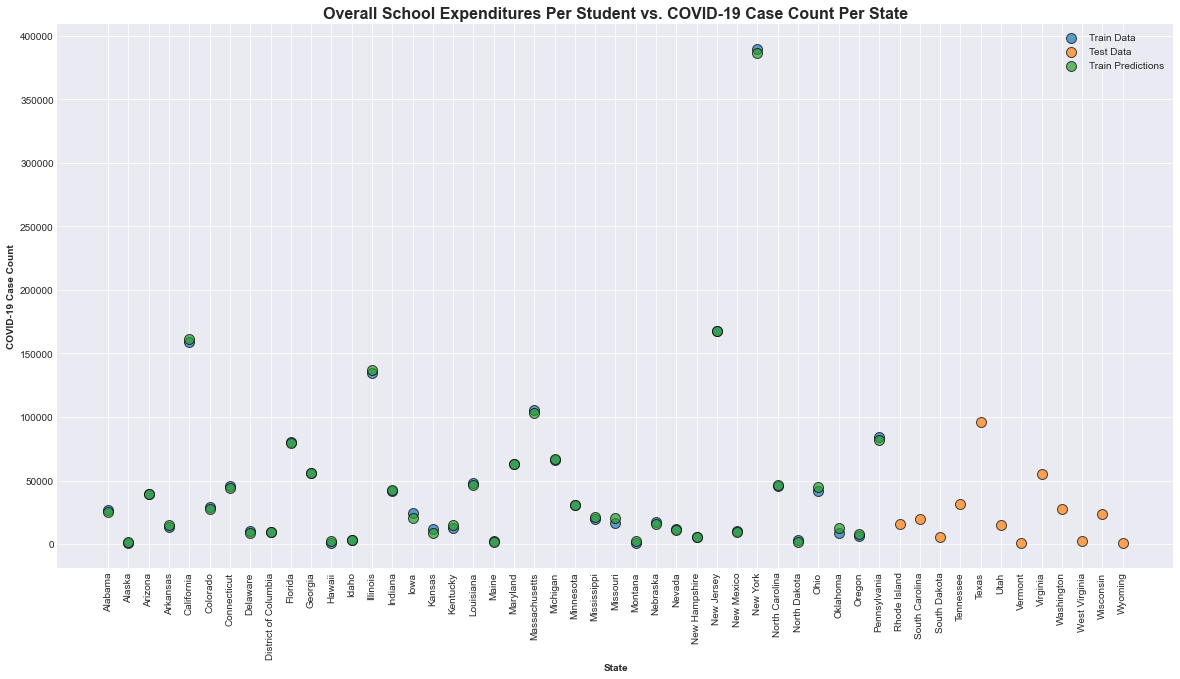

In [38]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall School Expenditures Per Student vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

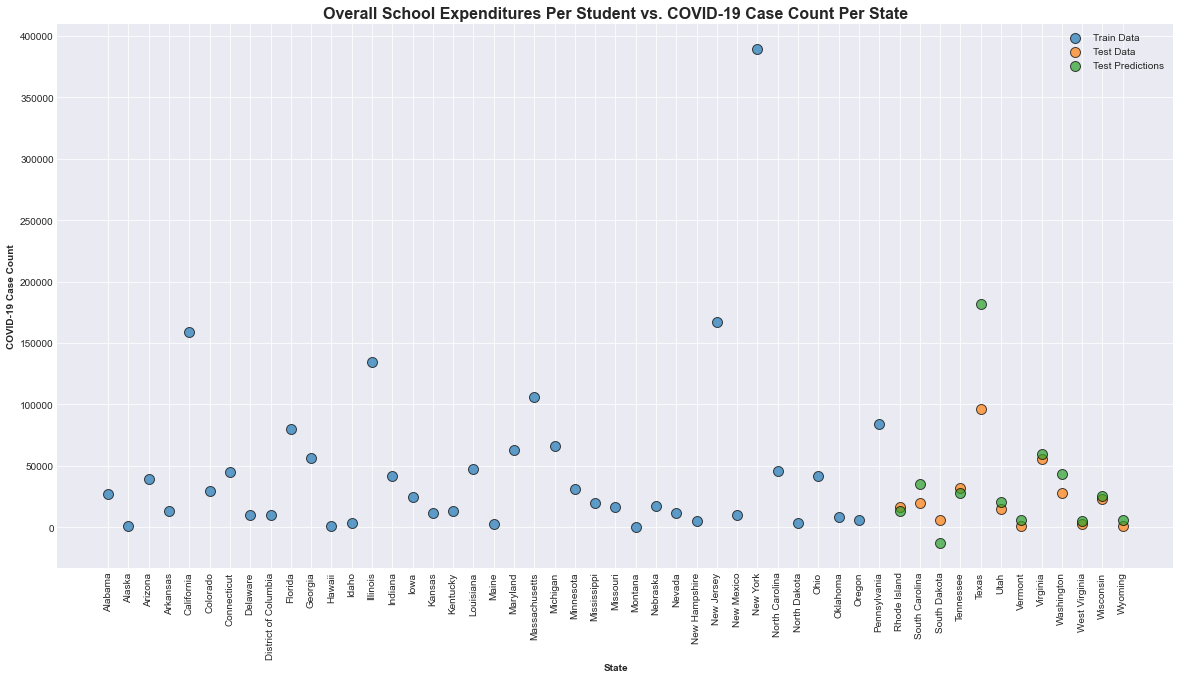

In [39]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall School Expenditures Per Student vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [40]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8309 degrees.
Accuracy = 91.25%.


In [41]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8295 degrees.
Accuracy = 91.25%.


In [42]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 0.00%.


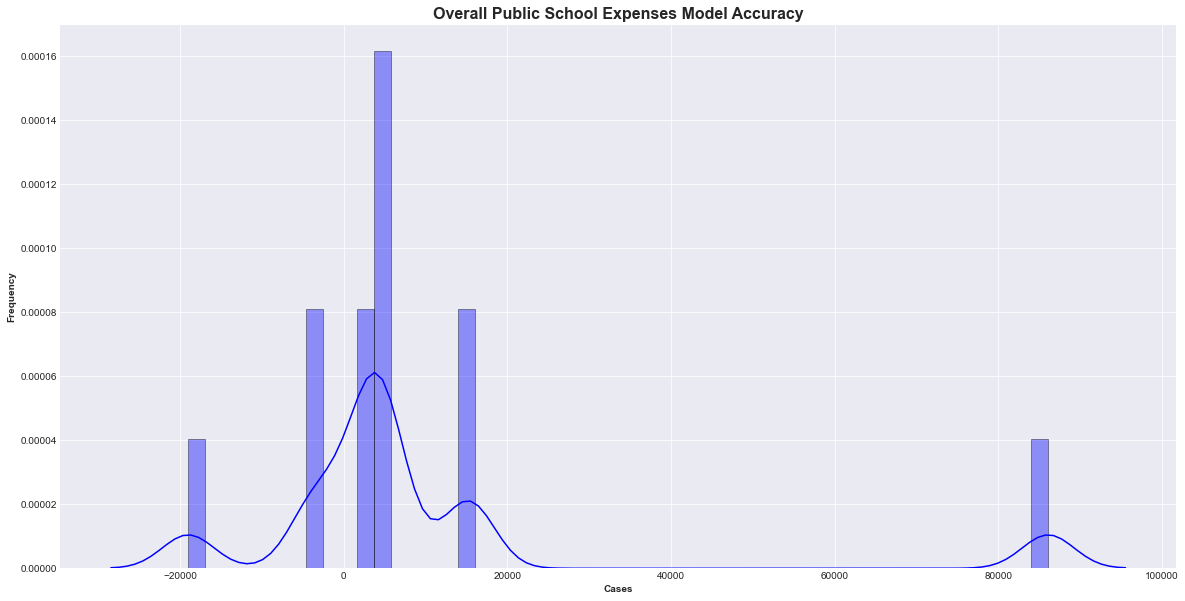

In [43]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Public School Expenses Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();